In [1]:
# Import and creating some helper functions
import copy

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def occlude(array):
    """
    Adds occlusion to an image.
    """
    new_array = copy.deepcopy(array)

    for k in range(len(new_array)):
        x = np.random.randint(0, 25)
        new_array[k, x: x + 2, :] = 1.0

    return new_array


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


In [6]:
tf.config.list_logical_devices("GPU")

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


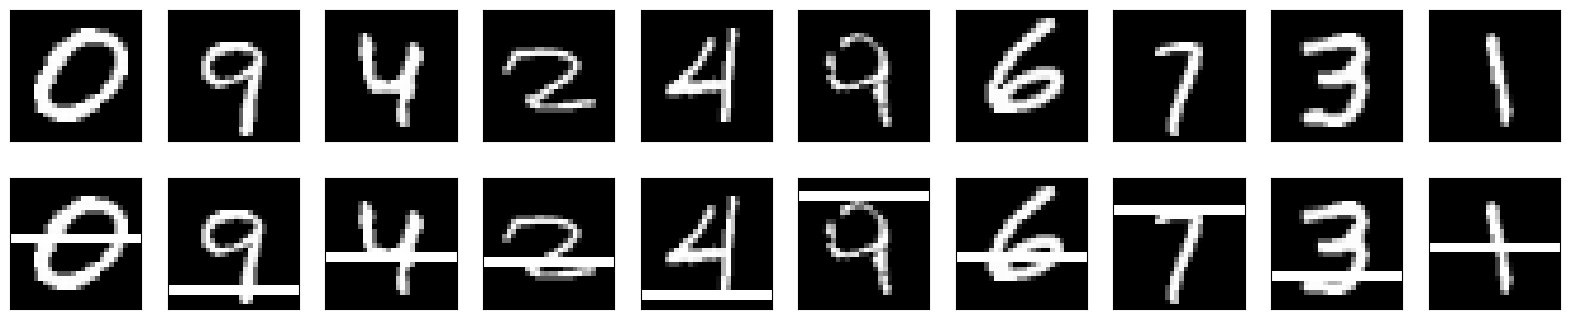

In [7]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = occlude(train_data)
noisy_test_data = occlude(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [8]:
# Our input shape is 28 x 28 x 1
input = layers.Input(shape=(28, 28, 1))

# The Encoder Model
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# The Decoder Model
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder - Note it is the entire concatenation of the encoder and decoder
autoencoder = Model(input, x)

autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
with tf.device("/device:GPU:0"):
  autoencoder.fit(
      x=train_data,
      y=train_data,
      epochs=50,
      batch_size=128,
      shuffle=True,
      validation_data=(test_data, test_data),
  )

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.2505 - val_loss: 0.0738
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0730 - val_loss: 0.0697
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0699 - val_loss: 0.0681
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0684 - val_loss: 0.0674
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0676 - val_loss: 0.0666
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0671 - val_loss: 0.0661
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0665 - val_loss: 0.0657
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0660 - val_loss: 0.0656
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0659 - val_loss: 0.0651
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0654 - val_loss: 0.0649
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0653 - val_loss: 0.0646
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/st

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


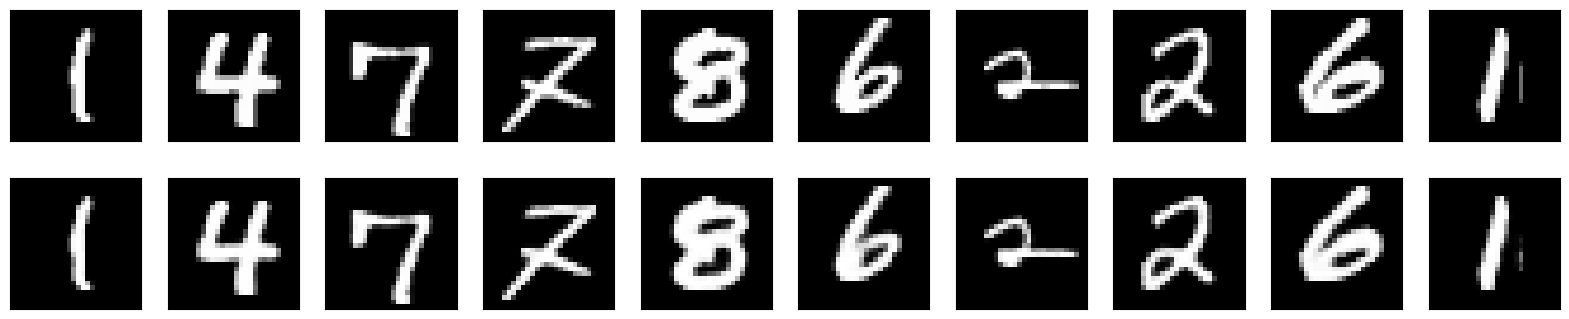

In [10]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [11]:
# Extracting the encoder part of the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[4].output)
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,568 (37.38 KB)

 Trainable params: 9,568 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Use the encoder to generate latent space representations
latent_train = encoder.predict(train_data)
latent_test = encoder.predict(test_data)
print(latent_test.shape)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(10000, 7, 7, 32)


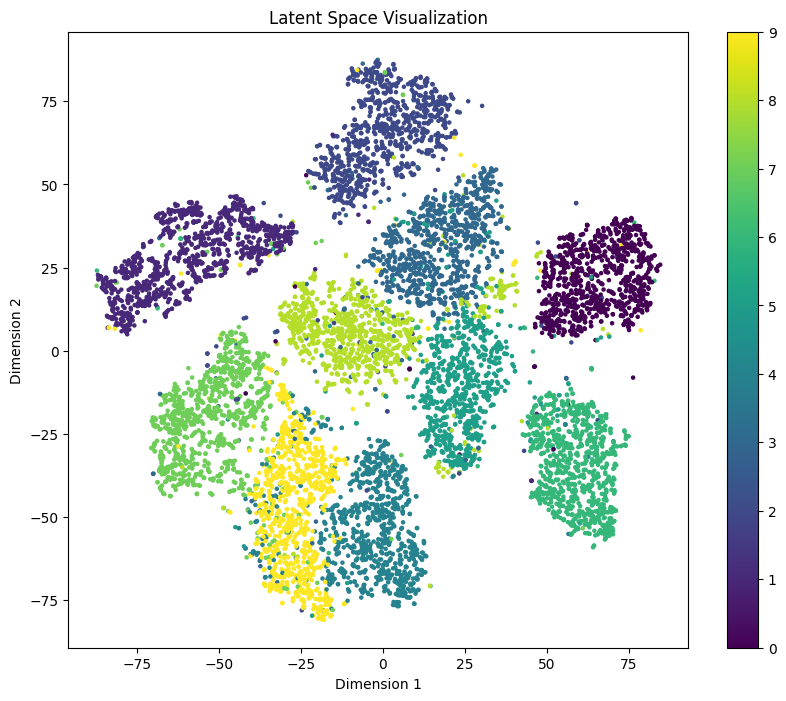

In [13]:
from sklearn.manifold import TSNE

# Reduce the dimensionality of the latent space to 2D using t-SNE
latent_2d = TSNE(n_components=2, random_state=42).fit_transform(latent_test.reshape(len(latent_test), -1))
#colors = np.random.rand(latent_2d.shape[0])
# Plot the 2D latent space
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1],  c=test_labels,cmap='viridis',  s=5)
plt.colorbar()
plt.title("Latent Space Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [14]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0929 - val_loss: 0.0712
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0714 - val_loss: 0.0696
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0700 - val_loss: 0.0692
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0697 - val_loss: 0.0688
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0693 - val_loss: 0.0684
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0688 - val_loss: 0.0684
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0686 - val_loss: 0.0683
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0686 - val_loss: 0.0679
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0685 - val_loss: 0.0679
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0684 - val_loss: 0.0680
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0683 - val_loss: 0.0676
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


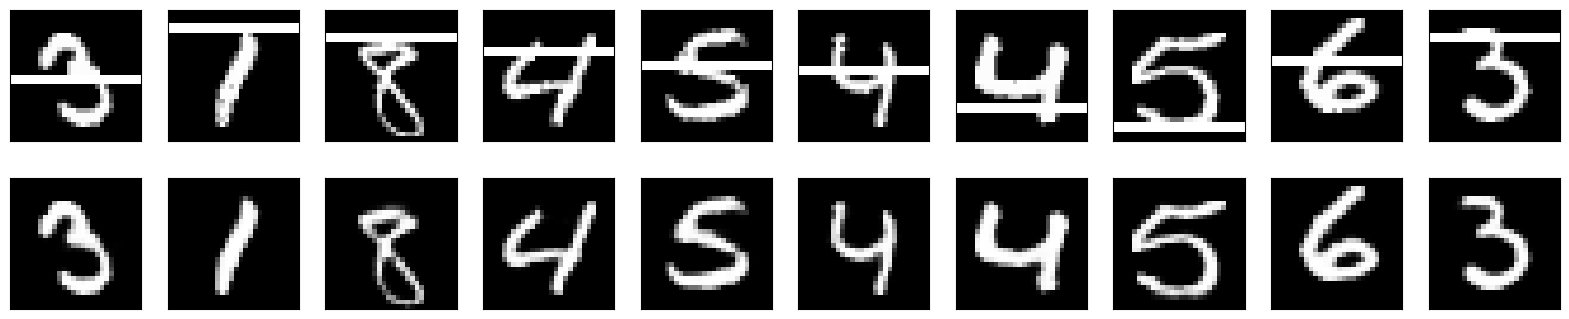

In [15]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)